# Lion co-localization problem
50 images of lions are extracted from inaturalist. This is a more difficult problem than the colocalization on Pascal VOC since the images are less precise and the object not alaways very observable. The dataset is unlabeled so the evaluation is done by observing the result of the algorithm on the 50 images it is applied to.  

## Imports 


In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import random
from scipy.optimize import minimize_scalar
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine.defaults import DefaultPredictor

import matplotlib.pyplot as plt
import matplotlib.patches as patches


## Calculate the box prior
$m$ is a vector computed from a saliency map that represents the likelihood of the box containing the object using only the current image.


In [2]:
def generate_saliency_map(image_path):
    # Load the image in color
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Create a saliency detector using the Spectral Residual method
    saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
    
    # Compute the saliency map for the given image
    (success, saliency_map) = saliency.computeSaliency(image)
    
    # Normalize the saliency map to the range [0, 255] for better visualization
    saliency_map = (saliency_map * 255).astype("uint8")

    return saliency_map

def calculate_m_vector(bounding_boxes, saliency_map):
    # Initialize a list to store the saliency values for each bounding box
    saliency_values = []
    
    for bbox in bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        
        # Ensure that the bounding box coordinates remain within the saliency map's bounds
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(saliency_map.shape[1], x_max)
        y_max = min(saliency_map.shape[0], y_max)
        
        # Extract the region corresponding to the bounding box
        region = saliency_map[y_min:y_max, x_min:x_max]
        
        # If the region is empty, assign a default low saliency value
        if region.size == 0:
            saliency_val = 0.0
        else:
            # Compute the saliency value for the region
            # Using the sum of saliency values to account for both intensity and size
            saliency_val = np.sum(region)
            
        saliency_values.append(saliency_val)
    
    # Convert the saliency values list to a NumPy array
    saliency_values = np.array(saliency_values, dtype=np.float32)
    
    # Compute the total saliency across all bounding boxes
    total = np.sum(saliency_values)
    
    # Avoid division by zero by assigning uniform weights if total saliency is too small
    if total < 1e-10:
        m_vector = np.ones_like(saliency_values) / len(saliency_values)
    else:
        # Normalize the saliency values to obtain the m-vector (proportional saliency)
        m_vector = saliency_values / total
    
    return m_vector


## Bounding boxes

We use R-CNN to have one good bounding box per image and then we compute 24 other random bounding boxes so the model can choose among random boxes or one good bounding box that detects the main common object of the image. It has been done like this to avoid a choice between many good boxes that would not enable us to distinguish is the model is working or not. 

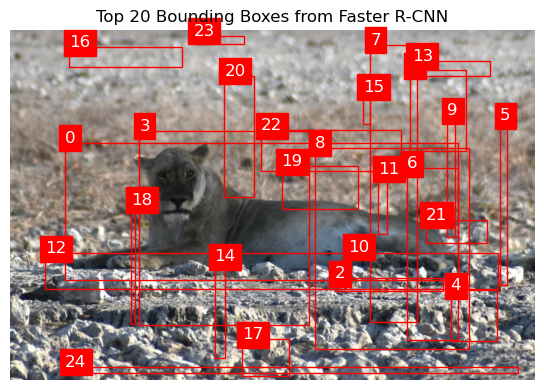

Number of boxes displayed: 25


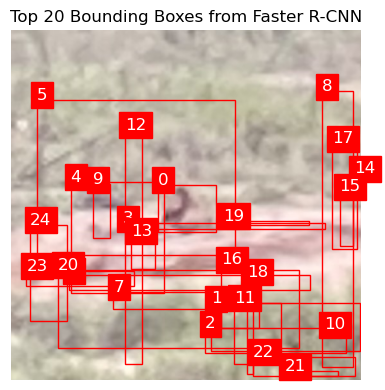

Number of boxes displayed: 25


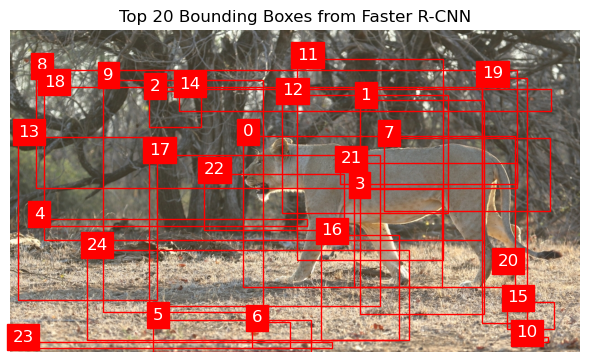

Number of boxes displayed: 25


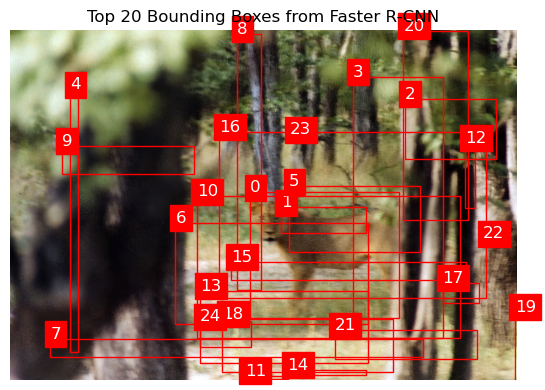

Number of boxes displayed: 25


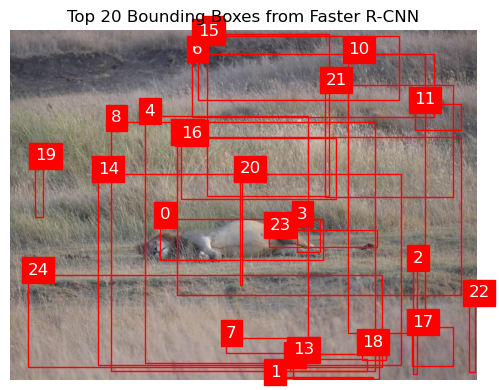

Number of boxes displayed: 25
Bounding boxes dictionary: {'/Users/theaudaudiffret/Documents/Documents/SCOLARITÉ/CS 3A/ovo/Project/lions_dataset/lion_77.jpg': [(106, 219, 875, 488), (780, 77, 890, 236), (634, 484, 845, 509), (252, 196, 583, 575), (860, 507, 951, 607), (957, 175, 971, 496), (774, 269, 874, 604), (703, 28, 794, 570), (595, 229, 897, 622), (854, 165, 868, 403), (660, 432, 666, 489), (719, 280, 736, 398), (68, 435, 953, 505), (784, 59, 937, 88), (399, 451, 419, 640), (689, 119, 703, 183), (115, 33, 336, 72), (453, 603, 544, 675), (236, 340, 243, 574), (530, 265, 680, 348), (418, 88, 476, 325), (812, 369, 932, 414), (490, 195, 764, 274), (358, 10, 457, 27), (107, 657, 992, 668)], '/Users/theaudaudiffret/Documents/Documents/SCOLARITÉ/CS 3A/ovo/Project/lions_dataset/lion_63.jpg': [(228, 241, 319, 315), (311, 426, 544, 500), (302, 465, 522, 503), (173, 301, 489, 310), (92, 236, 238, 409), (39, 108, 349, 351), (89, 382, 466, 405), (159, 408, 361, 435), (484, 95, 533, 525), (12

In [4]:
def process_images_and_get_boxes(input_folder):
    global_m_vector = []
    all_bounding_boxes = {}  # Dictionary to store bounding boxes for each image
    m_vectors = {}  # Dictionary to store m-vectors for each image
    plotted_count = 0  # Counter to limit the number of visualized images

    # Set up Faster R-CNN model
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01  # Set a low threshold for object detection
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.DEVICE = 'cpu'  # Use CPU for inference

    predictor = DefaultPredictor(cfg)  # Initialize the object detection model

    # Iterate over all images in the input folder
    for filename in os.listdir(input_folder):
        # Process only image files with specific extensions
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)  # Load the image

            if image is None:
                print(f"Error loading image: {filename}")
                continue

            saliency_map = generate_saliency_map(image_path)  # Generate saliency map for the image

            # Perform object detection
            outputs = predictor(image)
            
            # Extract bounding boxes and confidence scores
            boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
            scores = outputs["instances"].scores.cpu().numpy()

            # Sort boxes by confidence score in descending order and select top 25
            sorted_indices = np.argsort(scores)[::-1]
            top_20_boxes = boxes[sorted_indices[0]] # We keep only the first box

            # If fewer than 25 boxes are detected, generate random boxes
            while len(top_20_boxes) < 25:
                height, width = image.shape[:2]
                x1 = random.randint(0, width - 4)
                y1 = random.randint(0, height - 4)
                x2 = random.randint(x1 + 4, width)
                y2 = random.randint(y1 + 4, height)
                top_20_boxes = np.vstack((top_20_boxes, [x1, y1, x2, y2]))

            # Convert bounding boxes to a list of tuples (x1, y1, x2, y2)
            bounding_boxes = [(int(box[0]), int(box[1]), int(box[2]), int(box[3])) for box in top_20_boxes]

            all_bounding_boxes[image_path] = bounding_boxes  # Store bounding boxes
            m_vectors[image_path] = calculate_m_vector(bounding_boxes, saliency_map)  # Compute m-vector
            global_m_vector.extend(m_vectors[image_path].tolist())

            # Visualization for the first 5 images only
            if plotted_count < 5:
                # Plot the image with bounding boxes
                fig, ax = plt.subplots(1, figsize=(6, 4))
                ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                # Draw bounding boxes
                for i, box in enumerate(bounding_boxes):
                    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                             fill=False, edgecolor='red', linewidth=1)
                    ax.add_patch(rect)
                    ax.text(box[0], box[1], str(i), color='white', fontsize=12, backgroundcolor='red')

                ax.set_title('Top 20 Bounding Boxes from Faster R-CNN')
                ax.axis('off')
                plt.tight_layout()
                plt.show()

                print(f"Number of boxes displayed: {len(bounding_boxes)}")
                plotted_count += 1  # Increment visualization counter

    return all_bounding_boxes, global_m_vector  # Return dictionaries containing bounding boxes and m-vectors

input_folder = "/Users/theaudaudiffret/Documents/Documents/SCOLARITÉ/CS 3A/ovo/Project/lions_dataset"
# Call the function
bounding_boxes, global_m_vector = process_images_and_get_boxes(input_folder)
print("Bounding boxes dictionary:", bounding_boxes)


## Extract SIFT features 

In [10]:
def extract_sift_features(bounding_boxes):
    """
    Extracts SIFT features from given bounding boxes in images.
    
    """
    sift = cv2.SIFT_create()
    all_features = {}
    X = []
    
    for image_name, bboxes in bounding_boxes.items():
        image = cv2.imread(image_name)
        if image is None:
            continue  # Skip if image not found
        
        features = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            roi = image[y1:y2, x1:x2]
            if roi.size == 0:
                continue  # Skip empty ROIs
            
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            keypoints, descriptors = sift.detectAndCompute(gray_roi, None)
            
            if descriptors is not None and descriptors.size > 0:
                feature_vector = np.mean(descriptors, axis=0)
            else:
                feature_vector = np.zeros(128, dtype=np.float32)
            
            features.append(feature_vector)
            X.append(feature_vector)
        
        all_features[image_name] = features
    
    return np.array(X)

X = extract_sift_features(bounding_boxes)



# Optimization problem


## Box similarity 

$ L $ is the normalized Laplacian matrix defined as
$$
L = I - D^{-1/2} S\, D^{-1/2},
$$

In [11]:
def cosine_similarity_matrix(features):
    """
    Computes the cosine similarity matrix between feature vectors.
    """
    # Compute the L2 norm of each feature vector
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    
    # Normalize the feature vectors to unit length
    normalized_features = features / (norms + 1e-10)

    # Compute the cosine similarity matrix
    # The dot product gives cosine similarity, adjusted to be in range [0, 1]
    similarity_matrix = (np.dot(normalized_features, normalized_features.T) + 1) / 2

    return similarity_matrix


In [12]:
def compute_normalized_laplacian(features):
    """
    Computes the normalized Laplacian matrix from feature vectors.
    """
   # Compute the similarity matrix S using cosine similarity
    S = cosine_similarity_matrix(features)
    np.fill_diagonal(S, 0)

    row_sums = np.sum(S, axis=1)
    

    # Compute the inverse square root of D
    D_inv_sqrt = np.diag(1.0 / np.sqrt(row_sums + 1e-10))


    # Compute the normalized Laplacian matrix L
    L = np.eye(S.shape[0]) - D_inv_sqrt @ S @ D_inv_sqrt

    return L


## Box Discriminability


$ A $ is a discriminative clustering term  defined as
$$
A = \frac{1}{n_b}\left(\Pi_{n_b}\Bigl(I_{n_b} - X_{\text{box}}\Bigl(X_{\text{box}}^T \Pi_{n_b} X_{\text{box}} + n_b\kappa I\Bigr)^{-1}X_{\text{box}}^T\Bigr)\Pi_{n_b}\right),
$$
where the centering projection matrix is given by
$$
\Pi_{n_b} = I_{n_b} - \frac{1}{n_b}\mathbf{1}_{n_b}\mathbf{1}_{n_b}^T.
$$

In [13]:
def compute_discriminability_matrix(X_box, kappa):
    """
    Computes the discriminability matrix A for the given boxes.
    """

    nb_boxes = X_box.shape[0]  # Number of boxes (samples)

    d = X_box.shape[1]  # Feature dimension

    
    I_nb = np.eye(nb_boxes)  # Identity matrix of size (nb_boxes x nb_boxes)
    I_ = np.eye(d)  # Identity matrix of size (d x d)
    ones_nb = np.ones((nb_boxes, 1))  # Column vector of ones
    
    # Centering projection matrix
    P_nb = I_nb - (1 / nb_boxes) * (ones_nb @ ones_nb.T)  

    # Compute the inverse term
    inverse_term = np.linalg.inv(X_box.T @ P_nb @ X_box + nb_boxes * kappa * I_)

    # Compute the discriminative term
    discriminative_term = P_nb @ P_nb - P_nb @ X_box @ inverse_term @ X_box.T @ P_nb

    # Normalize by nb_boxes to obtain A
    A = (1 / nb_boxes) * discriminative_term

    return A



## Problem formulation 

The constraints ensure that we select exactly one box per image.
\begin{equation}
\min_{z} \; z^T (L + \mu A) z - \lambda\, z^T \log(m)
\end{equation}
subject to
$$
\forall I_j \in I: \quad \sum_{k=1}^{m} z_{j,k} = 1,
$$


In [28]:
n = len(bounding_boxes) # number of images
m = len(bounding_boxes["/Users/theaudaudiffret/Documents/Documents/SCOLARITÉ/CS 3A/ovo/Project/lions_dataset/lion_1.jpg"]) # number of bounding boxes per image
n_b = n*m # total number of bounding boxes

lambda_ = 0.4  # Regularization parameter
mu = 50 # Trade-off parameter
A = compute_discriminability_matrix(X, 10)  # Compute discriminability matrix
L = compute_normalized_laplacian(X)  # Compute normalized Laplacian matrix

global_m_vector = np.array(global_m_vector)

# objective function and gradient
def f(z):
    return z.T @ (L+mu*A) @ z - lambda_ * z.T @ np.log(global_m_vector + 1e-10)

def grad_f(z):
    return 2* (L+mu*A) @ z - lambda_ * np.log(global_m_vector + 1e-10)



# Frank-Wolfe algorithm

On a convex set $ \mathcal{D} $, the Frank-Wolfe algorithm finds the global minimum of $ f $ over $ \mathcal{D} $ by solving a succession of linear problems over the convex set:

\begin{equation}
    \min_{y} \quad y^T \nabla f(z_{k-1})
    \quad \text{subject to} \quad y \in \mathcal{D}.
\end{equation}

And update:

\begin{equation}
    z_k = z_{k-1} + \lambda (y_k - z_{k-1}),
\end{equation}


For each image, we can take the argmin of the cost function over the constraints since the problem is separable. The complexity is $\mathcal{O}(n*m)$ instead of $\mathcal{O}(n*m*log(n*m)$ for a projected gradient algorithm.

In [29]:
image_indices = {}
start = 0
for image in sorted(bounding_boxes.keys()):
    end = start + len(bounding_boxes[image])
    image_indices[image] = (start, end)
    start = end

In [30]:

def optimize_bounding_boxes(f, gradient_f, n_b, max_iterations=100):
    # Data initialization
    y0 = np.zeros(n_b)
    for image, (start, end) in image_indices.items():
        idx = np.random.randint(start, end)
        y0[idx] = 1.0
    
    # Initialization
    k = 0
    z = y0
    S = {tuple(y0)}  # Active set as immutable tuples
    y_star = y0
    objective_values = []
    objective_discret_values = []
    rounding_count = 0
    
    print(f(z))
    
    # Iterations
    for k in range(1, max_iterations + 1):
        objective_values.append(f(z))
        objective_discret_values.append(f(y_star))
        
        y_k = np.zeros(n_b)
        # Forward direction
        for image, (start, end) in image_indices.items():
            grad_f = gradient_f(z)
            y_k[start:end] = 0
            y_k[start + np.argmin(grad_f[start:end])] = 1        
        # Away step
        max_val = -np.inf
        for s in S:
            s = np.array(s)
            if s.T @ grad_f > max_val:
                max_val = s.T @ grad_f
                x_k = s
        
        # Choosing descent direction
        if (y_k - z).T @ grad_f <= (z - x_k).T @ grad_f:
            d_k = y_k - z
            gamma_max = 1
        else:
            d_k = z - x_k
            gamma_max = 0.2 # we could have improved this gamma_max choice with the supplementary material of the paper
            
        # Line search
        res = minimize_scalar(lambda gamma: f(z + gamma * d_k), bounds=(0, gamma_max), method='bounded')
        gamma_k = res.x
        
        S = S.union({tuple(z + gamma_k * d_k)})
        
        # Update
        z = z + gamma_k * d_k
        
        if f(y_k) < f(y_star):
            y_star = y_k
            rounding_count += 1
        
        if k % 20 == 0:
            print(f"Iteration {k}, f(y_star) = {f(y_star)}")
    
    # Rounding 2: Find y_r that maximizes <y, z>
    y_r = np.zeros(n_b)
    for image, (start, end) in image_indices.items():
        subvector_z = z[start:end]
        y_r[start + np.argmax(subvector_z)] = 1
    
    # Combine rounding results if necessary
    if f(y_r) < f(y_star):
        print("ROUNDING 2")
        y_star = y_r
        objective_discret_values.append(f(y_star))
    else:
        print("NO ROUNDING 2")
    
    print(f"Converged in {k} iterations")
    print(f"Rounding 1 count: {rounding_count}")
    print(f"Final objective value: {f(y_star)}")
    
    # Plot convergence
    plt.plot(objective_values)
    plt.plot(objective_discret_values)
    plt.legend(['Continuous', 'Discrete'])
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.title('Convergence of the Algorithm')
    plt.show()
    
    return y_star


136.10810113395286
Iteration 20, f(y_star) = 80.39507662800428
Iteration 40, f(y_star) = 80.39507662800428
ROUNDING 2
Converged in 40 iterations
Rounding 1 count: 1
Final objective value: 80.09892127277544


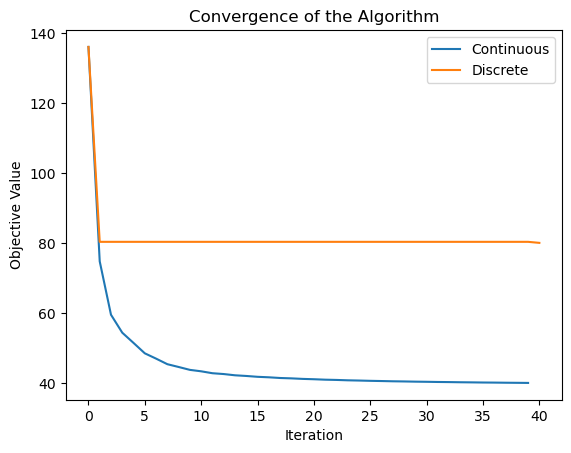

In [35]:
y_star = optimize_bounding_boxes(f, grad_f, n_b, max_iterations=40)


# Vizualization of the results

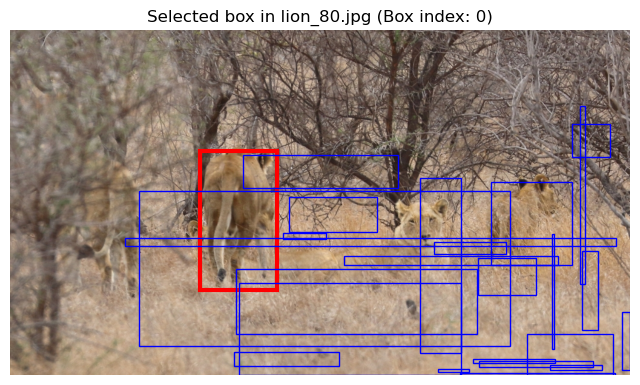

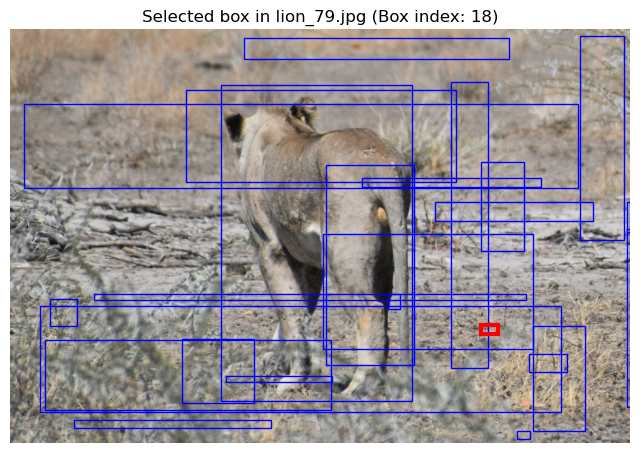

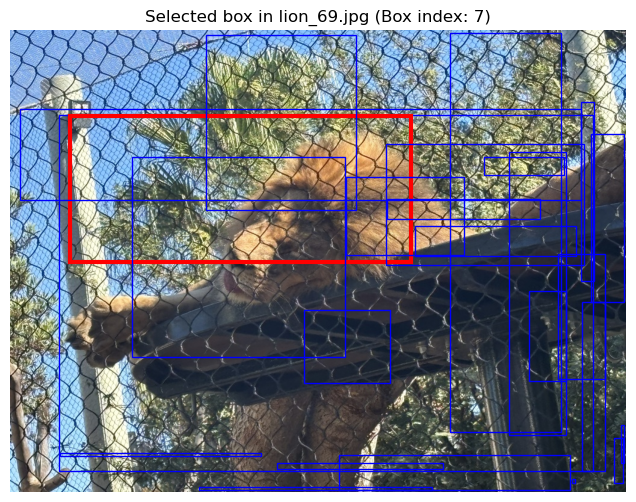

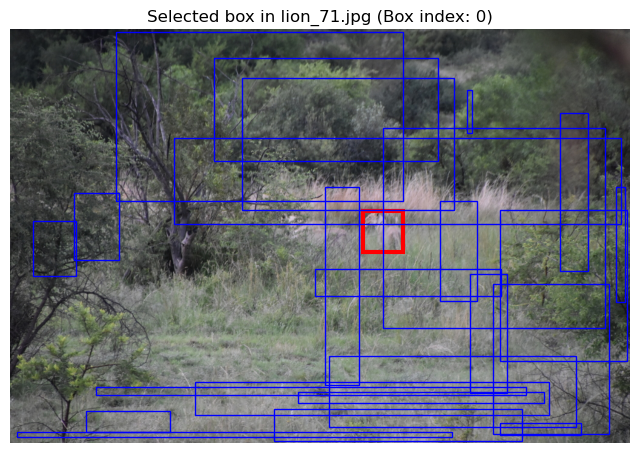

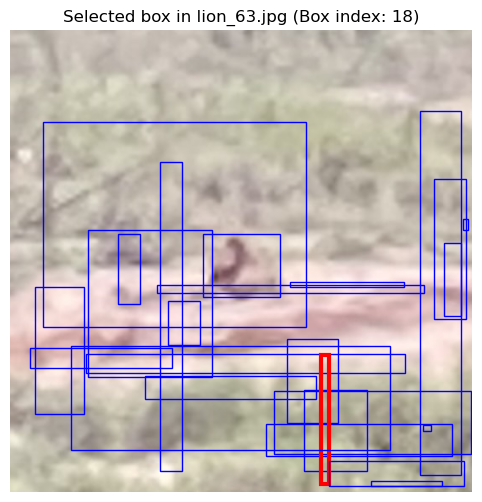

In [38]:
sampled_images = random.sample(sorted(bounding_boxes.keys()), 5)

for image_path in sampled_images:
    # Get the index range for the current image from image_indices
    start_idx, end_idx = image_indices[image_path]
    
    # Determine the selected bounding box index for this image
    selected_offset = np.argmax(y_star[start_idx:end_idx])
    
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue
    
    # Convert BGR to RGB for proper display with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create the plot
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(image_rgb)
    
    # Loop over all bounding boxes and draw them (selected in red; others in blue)
    for i, bbox in enumerate(bounding_boxes[image_path]):
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        color = 'red' if i == selected_offset else 'blue'
        linewidth = 3 if i == selected_offset else 1

        rect = patches.Rectangle((x1, y1), width, height, fill=False, edgecolor=color, linewidth=linewidth)
        ax.add_patch(rect)
    
    ax.set_title(f"Selected box in {os.path.basename(image_path)} (Box index: {selected_offset})")
    ax.axis('off')
    plt.show()
